# Model Correction
This was the notebook I used to find the r-az lens correction. There are dangling fragments of other models I tried in here as well.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

from mpl_toolkits.mplot3d import Axes3D

xy.txt is a file where each line is of the following form: x1, y1, alt1, az1, x2, y2, alt2, az2 where 1 denotes the coordinates as they appear on the image. And 2 denotes the coordinates as the conversion spits them out. The 1 subscripted versions are found using the coordinates.find_star method.

In [3]:
f = open('xy.txt', 'r')

center = (256, 252)

xpoints = []
ypoints = []
azpoints = []
altpoints = []
azcamera = []
altcamera = []
xreal = []
yreal = []
for line in f:
    # Strips new line
    line = line[:-2]
    nums = line.split(', ')
    
    # Reading all them points lol.
    xpoints.append(float(nums[0]) - center[0])
    ypoints.append(center[1] - float(nums[1]))
    altcamera.append(float(nums[2]))
    azcamera.append(float(nums[3]))
    xreal.append(float(nums[4]) - center[0])
    yreal.append(center[1] - float(nums[5]))
    altpoints.append(float(nums[6]))
    azpoints.append(float(nums[7]))
f.close()  

Plot the points we're using to determine this conversion as they're distributed around the image. You can trace the paths of some of the bright stars I used to determine this conversion in their circular paths, as well as Polaris which remains roughly stationary.

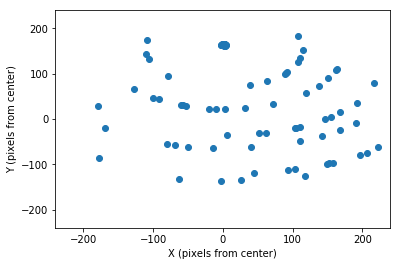

In [4]:
plt.scatter(xpoints, ypoints)
plt.ylabel("Y (pixels from center)")
plt.xlabel("X (pixels from center)")

plt.xlim(-240,240)
plt.ylim(-240,240)

plt.show()

The next card is the same plot but with the true x and y pixel coordinates found using altaz_to_xy.

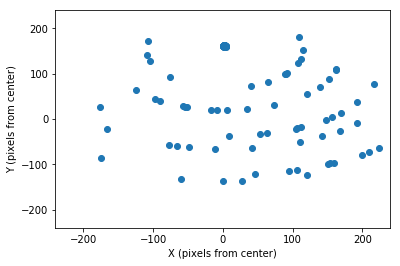

In [5]:
plt.scatter(xreal, yreal)
plt.ylabel("Y (pixels from center)")
plt.xlabel("X (pixels from center)")

plt.xlim(-240,240)
plt.ylim(-240,240)

plt.show()

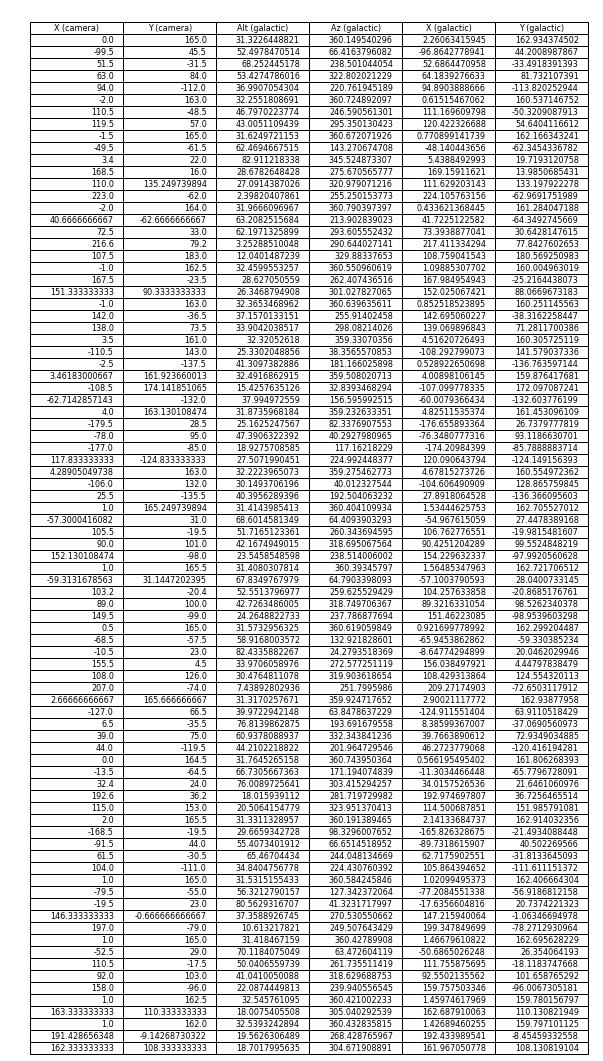

In [5]:
columns = ['X (camera)', 'Y (camera)', 'Alt (galactic)', 'Az (galactic)', 'X (galactic)', 'Y (galactic)']


datalist = np.zeros((len(xpoints),6))

for i in range(0,len(xpoints)):
    datalist[i,0] = xpoints[i]
    datalist[i,1] = ypoints[i]
    datalist[i,2] = altpoints[i]
    datalist[i,3] = azpoints[i]
    datalist[i,4] = xreal[i]
    datalist[i,5] = yreal[i]

fig, ax = plt.subplots(figsize = (10,10))

#ax = plt.subplot2grid((1,1), (0,0))
ax.table(cellText=datalist,
          colLabels=columns, loc="upper center")

ax.axis("off")
plt.show()

### Method 1
The first try conversion used a cosine/sine transformation that uses two variables, alpha and beta, to define the coordinate conversion. In order to find the corrected conversion we use a chi-squared test.

In [6]:
def xconv(alpha, beta, xreal, yreal):
    alpha = math.radians(alpha)
    beta = math.radians(beta)
    x = math.cos(alpha)*xreal + math.sin(alpha)*yreal
    
    #x = alpha * xreal + beta*yreal
    return x

def yconv(alpha, beta, xreal, yreal):
    alpha = math.radians(alpha)
    beta = math.radians(beta)
    
    #y = -math.sin(alpha)*math.cos(beta)*xreal + math.cos(alpha)*math.cos(beta)*yreal
    y = (-math.sin(alpha)/math.cos(beta))*xreal + (math.cos(alpha)/math.cos(beta))*yreal
    
    #y = alpha*yreal + beta*xreal
    
    return y

def chisquared(alpha, beta):
    sum = 0
    for i in range(0,len(xpoints)):
        chi = (xpoints[i] - xconv(alpha, beta, xreal[i], yreal[i]))**2 + (ypoints[i] - yconv(alpha, beta, xreal[i], yreal[i]))**2
        sum += chi
    return sum




In [7]:
betalist = []
alphalist = []
chilist = []
beta = 0
while beta <= 10:
    alpha = 0
    #while alpha <= 360:
    chi = chisquared(alpha, beta)
    alphalist.append(alpha)
    betalist.append(beta)
    chilist.append(chi)
        #alpha += 1
    beta += 0.5

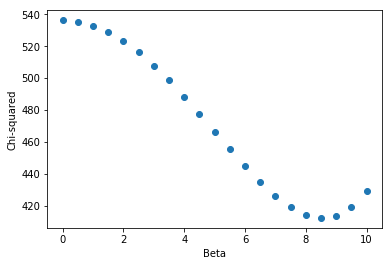

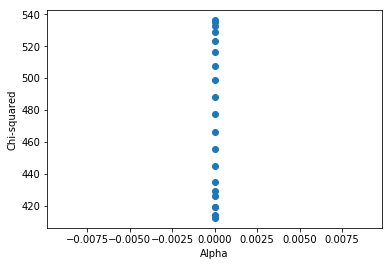

In [8]:
plt.scatter(betalist,chilist)
plt.ylabel("Chi-squared")
plt.xlabel("Beta")
plt.show()

plt.scatter(alphalist,chilist)
plt.ylabel("Chi-squared")
plt.xlabel("Alpha")
plt.show()

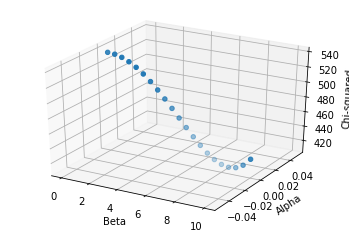

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(betalist, alphalist, chilist)
ax.set_xlabel('Beta')
ax.set_ylabel('Alpha')
ax.set_zlabel('Chi-squared')

plt.show()

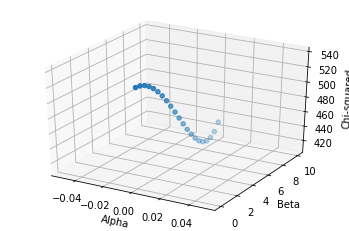

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(alphalist, betalist, chilist)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Chi-squared')

plt.show()

This ensures that the alt and az above 360 loop back around, as they should because it's a circle.

In [12]:
for i in range(0,len(azpoints)):
    if azpoints[i] > 360:
        azpoints[i] = azpoints[i] - 360
    if azcamera[i] > 360:
        azcamera[i] = azcamera[i] - 360


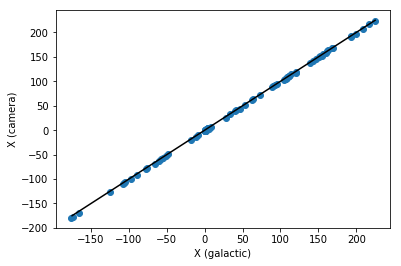

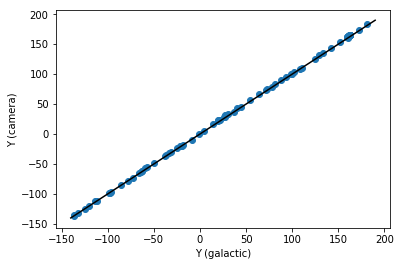

In [13]:
def xy(x):
    return x #- 1

def yx(y):
    return y #+ 2

t1 = np.arange(-175, 225, 0.1)
t2 = np.arange(-140, 190, 0.1)

plt.scatter(xreal,xpoints)
plt.ylabel("X (camera)")
plt.xlabel("X (galactic)")
plt.plot(t1, xy(t1), 'k')
plt.show()

plt.scatter(yreal,ypoints)
plt.ylabel("Y (camera)")
plt.xlabel("Y (galactic)")
plt.plot(t2, yx(t2), 'k')
plt.show()

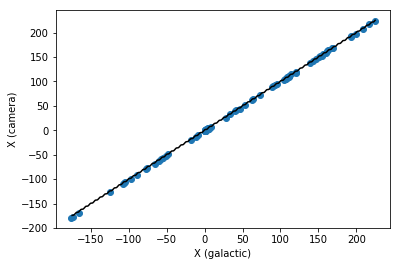

In [14]:
def xy(x,f):
    return x + f*np.cos(x)

t1 = np.arange(-175, 225, 0.1)

plt.scatter(xreal,xpoints)
plt.ylabel("X (camera)")
plt.xlabel("X (galactic)")
plt.plot(t1, xy(t1,1), 'k')
plt.show()

### Method 2
The second attempt uses a conversion of the form `x = x + f*cos(x))` and `y = y + g*cos(y))`. Again we use a chi squared analysis to find the best values of `f` and `g`.

In [15]:
def xconv(x, y, f, g):
    x = x + f*math.cos(math.radians(x))
    return x

def yconv(x, y, f, g):
    y = y + g*math.cos(math.radians(y))
    return y

def conv(x,y,az,f,g,h):
    r = math.sqrt(x**2 + y**2)
    az = az - .94444
    
     
    az = az - 0.731*math.cos(math.radians(0.993 * (az + 34.5))) + 0.181
    r = r - 2.358 * math.cos(math.radians(0.99 * (az - 40.8))) - 0.729
    
    #x = -1 * r * math.sin(math.radians(az))
    #y = r * math.cos(math.radians(az))
    
    return (x,y)

def chisquared(f,g,h):
    sum = 0
    for i in range(0,len(xpoints)):
        change = conv(xpoints[i], ypoints[i], azcamera[i], f, g,h)
        chi = (xreal[i] - change[0])**2 + (yreal[i] - change[1])**2
        sum += chi
    return sum

Optimize is the method that iterates through values of `f` and `g` looking for the minimum chi-squared value. In hindsight I'm not sure why I implemented this by hand, as I'm pretty sure I could have used scipy to do this.

In [16]:
def optimize():
    tuples = []
    f = 0
    while f <= 3:
        g = 45
        while g <= 45:
            h = 32
            while h <= 32:
                chi = chisquared(f,g,h)
                tuples.append((chi,f,g,h))
                h += .001
            g += .01
        f += .001
    tuples = sorted(tuples)
    
    return tuples[0]


best = optimize()
print(best)

(536.2964082405673, 0, 45, 32)


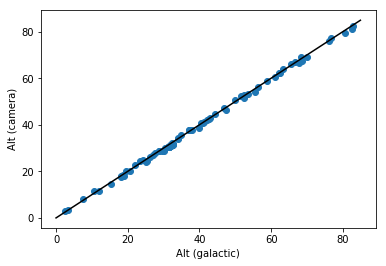

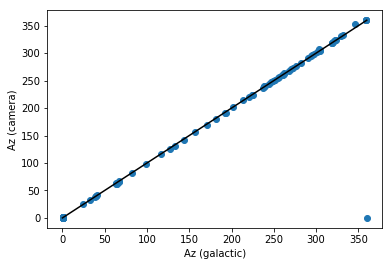

In [17]:
def xy(x):
    return x# + np.sin((x))

t1 = np.arange(0.0, 85.0, 0.1)
t2 = np.arange(0.0, 360.0, 0.1)

plt.scatter(altpoints,altcamera)
plt.ylabel("Alt (camera)")
plt.xlabel("Alt (galactic)")
plt.plot(t1, xy(t1), 'k')
plt.show()

plt.scatter(azpoints,azcamera)
plt.ylabel("Az (camera)")
plt.xlabel("Az (galactic)")
plt.plot(t2, xy(t2), 'k')
plt.show()

### Method 3
The third attempt used a very similar method to the second try but used alt and az instead of x and y. This method ended up being more accurate. The conversion method is `alt = alt + sin(g * alt + f)`

In [19]:
def altconv(alt,az,f,g):
    alt = math.sin(g * alt + f) + alt
    return alt

def azconv(alt,az,f,g):
    return az

def altazchi(f,g):
    sum = 0
    for i in range(0,len(azpoints)):
        # There's at least 1 instance where it rolls over.
        if azpoints[i] > 350 and azcamera[i] < 10:
            chi = (azpoints[i] - azconv(altcamera[i], (azcamera[i]+360),f,g))**2 + (altpoints[i] - altconv(altcamera[i], azcamera[i],f,g))**2
        else:
            chi = (azpoints[i] - azconv(altcamera[i], azcamera[i],f,g))**2 + (altpoints[i] - altconv(altcamera[i],azcamera[i],f,g))**2
        sum += chi
    return sum

In [20]:
def altazoptimize():
    chilist = []
    tuples = []
    f = -20
    while f <= 20:
        g = -10
        while g <= 10:
            chi = altazchi(f,g)
            chilist.append(chi)
            tuples.append((chi,f,g))
            g += 1
        f += 1
    tuples = sorted(tuples)
    
    return tuples[0]
    
best = altazoptimize()
print(best)

(153.61034474638586, -16, 0)


Bluntly I actually don't remember why this following method exists. I think it accounts fo the one alt/az rolls over, as you can see in the above galactic alt/az plot where there's a point in the lower right that's overrun due to it's angular position. On the bright side the best chi-squared came down to about 153-154. Since we have about 100 pixel values, this comes out to be an inaccuracy of less than a pixel on average. Given the pixel density of the image being so incredibly high, and hence pixels being rather large, this is actually really good!

In [22]:
def currchi():
    sum = 0
    for i in range(0,len(azpoints)):
        # There's at least 1 instance where it rolls over.
        if azpoints[i] > 350 and azcamera[i] < 10:
            chi = (azpoints[i] - (azcamera[i]+360))**2 + (altpoints[i] - altcamera[i])**2
        else:
            chi = (azpoints[i] - azcamera[i])**2 + (altpoints[i] - altcamera[i])**2
        sum += chi
    return sum

currchi()

161.92631108389946

It should be noted here that much of the code was also run with galactic/image coordinates flipped, especially in method 3. This is because the function `alt = alt + sin(g * alt + f)` does not have an analytic inverse, and hence the closest inverse function is a function of the same form with different `f` and `g` values.